In [16]:
import keras
from keras import optimizers
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb, rgb2hsv, hsv2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow.contrib.eager as tfe
import os
from os.path import expanduser
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from lsuv_init import LSUVinit

In [2]:
SHUFFLE_BUFFER = 200
BATCH_SIZE = 32
FILE_NAME = expanduser("~") + '/imagenet/tfrecords/0.tfrecords'
def parse_function(proto):
    
    parsed_features = tf.parse_single_example(
        proto,
        features={
        'image_gray': tf.FixedLenFeature([], tf.string),
        'image_a_b': tf.FixedLenFeature([], tf.string),
        'embedding': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.string),
    })

    image_gray = tf.decode_raw(parsed_features['image_gray'], tf.uint8)
    image_a_b = tf.decode_raw(parsed_features['image_a_b'], tf.float32)
    embedding = tf.decode_raw(parsed_features['embedding'], tf.float32)
    return image_gray, image_a_b, embedding

def create_dataset(filepath):
    dataset = tf.data.TFRecordDataset(filepath)
    dataset = dataset.map(parse_function, num_parallel_calls=4)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(SHUFFLE_BUFFER)
    dataset = dataset.batch(BATCH_SIZE)
    
    iterator = dataset.make_one_shot_iterator()
    image_gray, image_a_b, embedding = iterator.get_next()
    image_gray = tf.reshape(image_gray, [-1, 224, 224, 1])
    image_gray = tf.cast(image_gray, tf.float32)
    image_a_b = tf.reshape(image_a_b, [-1, 224, 224, 2])
    embedding = tf.reshape(embedding, [-1, 1000])
    return image_gray, image_a_b, embedding

In [4]:
image_gray, image_a_b, embedding = create_dataset(FILE_NAME)
embed_input = Input(tensor=embedding)

#Encoder
encoder_input = Input(tensor=image_gray)
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = BatchNormalization()(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = BatchNormalization()(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = BatchNormalization()(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(28 * 28)(embed_input) 
fusion_output = Reshape(([28, 28, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = BatchNormalization()(decoder_output)
decoder_output = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = BatchNormalization()(decoder_output)
decoder_output = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3, 3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = BatchNormalization()(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 112, 112, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 112, 112, 64) 256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 112, 112, 128 73856       batch_normalization_7[0][0]      
__________________________________________________________________________________________________
conv2d_17 

In [5]:
def lr_schedule(epoch):
    # Learning Rate Schedule
    lr = 1e-3
    if epoch > 100:
        lr *= 0.1
    if epoch > 150:
        lr *= 0.1
    if epoch > 200:
        lr *= 0.1
    if epoch > 300:
        lr *= 0.1
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)
tbCallBack = TensorBoard(log_dir='./Graph2', histogram_freq=0, write_graph=True, write_images=True)
checkpoint = ModelCheckpoint('colorization_model.h5', monitor='loss', save_best_only = True, verbose=1, mode='min')
callbacks = [checkpoint, tbCallBack, lr_scheduler]

In [6]:
#Train model    
epochs = 10000
adam = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, 
              loss='mse',
              target_tensors=[image_a_b])
model.fit(epochs=epochs,
         steps_per_epoch=8000 // BATCH_SIZE, verbose=1,callbacks=callbacks)

Epoch 1/10000
Learning rate:  0.001
250/250 [==============================] - 40s 161ms/step - loss: 223.4294

Epoch 00001: loss improved from inf to 223.42944, saving model to colorization_model.h5
Epoch 2/10000
Learning rate:  0.001
250/250 [==============================] - 38s 154ms/step - loss: 219.2327

Epoch 00002: loss improved from 223.42944 to 219.23268, saving model to colorization_model.h5
Epoch 3/10000
Learning rate:  0.001
250/250 [==============================] - 39s 155ms/step - loss: 216.9951

Epoch 00003: loss improved from 219.23268 to 216.99512, saving model to colorization_model.h5
Epoch 4/10000
Learning rate:  0.001
250/250 [==============================] - 39s 155ms/step - loss: 213.1910

Epoch 00004: loss improved from 216.99512 to 213.19096, saving model to colorization_model.h5
Epoch 5/10000
Learning rate:  0.001
250/250 [==============================] - 39s 157ms/step - loss: 211.1669

Epoch 00005: loss improved from 213.19096 to 211.16691, saving model t

Epoch 44/10000
Learning rate:  0.001
250/250 [==============================] - 39s 158ms/step - loss: 75.3401

Epoch 00044: loss improved from 77.45508 to 75.34005, saving model to colorization_model.h5
Epoch 45/10000
Learning rate:  0.001
250/250 [==============================] - 39s 157ms/step - loss: 72.8532

Epoch 00045: loss improved from 75.34005 to 72.85316, saving model to colorization_model.h5
Epoch 46/10000
Learning rate:  0.001
250/250 [==============================] - 39s 157ms/step - loss: 70.7322

Epoch 00046: loss improved from 72.85316 to 70.73221, saving model to colorization_model.h5
Epoch 47/10000
Learning rate:  0.001
250/250 [==============================] - 39s 158ms/step - loss: 69.4556

Epoch 00047: loss improved from 70.73221 to 69.45555, saving model to colorization_model.h5
Epoch 48/10000
Learning rate:  0.001
250/250 [==============================] - 39s 157ms/step - loss: 66.6272

Epoch 00048: loss improved from 69.45555 to 66.62722, saving model to co

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 157ms/step - loss: 38.2550

Epoch 00091: loss improved from 38.82137 to 38.25501, saving model to colorization_model.h5
Epoch 92/10000
Learning rate:  0.001
250/250 [==============================] - 39s 158ms/step - loss: 38.2857

Epoch 00092: loss did not improve from 38.25501
Epoch 93/10000
Learning rate:  0.001
250/250 [==============================] - 39s 158ms/step - loss: 38.1844

Epoch 00093: loss improved from 38.25501 to 38.18443, saving model to colorization_model.h5
Epoch 94/10000
Learning rate:  0.001
250/250 [==============================] - 40s 159ms/step - loss: 37.4464

Epoch 00094: loss improved from 38.18443 to 37.44642, saving model to colorization_model.h5
Epoch 95/10000
Learning rate:  0.001
250/250 [==============================] - 40s 159ms/step - loss: 37.4897

Epoch 00095: loss did not improve from 37.44642
Epoch 96/10000
Learning rate:  0.001
250/250 [==============================] - 40s 159ms/step - loss: 37

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 158ms/step - loss: 30.1318

Epoch 00141: loss improved from 30.20894 to 30.13176, saving model to colorization_model.h5
Epoch 142/10000
Learning rate:  0.0001
250/250 [==============================] - 40s 159ms/step - loss: 29.9073

Epoch 00142: loss improved from 30.13176 to 29.90733, saving model to colorization_model.h5
Epoch 143/10000
Learning rate:  0.0001
250/250 [==============================] - 40s 158ms/step - loss: 29.8916

Epoch 00143: loss improved from 29.90733 to 29.89159, saving model to colorization_model.h5
Epoch 144/10000
Learning rate:  0.0001
250/250 [==============================] - 39s 157ms/step - loss: 29.8357

Epoch 00144: loss improved from 29.89159 to 29.83573, saving model to colorization_model.h5
Epoch 145/10000
Learning rate:  0.0001
250/250 [==============================] - 40s 160ms/step - loss: 29.6754

Epoch 00145: loss improved from 29.83573 to 29.67538, saving model to colorization_model.h5
Epoch 146

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 40s 158ms/step - loss: 30.5673

Epoch 00193: loss did not improve from 29.24143
Epoch 194/10000
Learning rate:  1e-05
250/250 [==============================] - 39s 158ms/step - loss: 30.4532

Epoch 00194: loss did not improve from 29.24143
Epoch 195/10000
Learning rate:  1e-05
250/250 [==============================] - 39s 158ms/step - loss: 30.2139

Epoch 00195: loss did not improve from 29.24143
Epoch 196/10000
Learning rate:  1e-05
250/250 [==============================] - 40s 158ms/step - loss: 29.9350

Epoch 00196: loss did not improve from 29.24143
Epoch 197/10000
Learning rate:  1e-05
250/250 [==============================] - 39s 158ms/step - loss: 30.1592

Epoch 00197: loss did not improve from 29.24143
Epoch 198/10000
Learning rate:  1e-05
250/250 [==============================] - 39s 157ms/step - loss: 30.3268

Epoch 00198: loss did not improve from 29.24143
Epoch 199/10000
Learning rate:  1e-05
250/250 [=========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 40s 160ms/step - loss: 29.3427

Epoch 00246: loss did not improve from 29.24143
Epoch 247/10000
Learning rate:  1.0000000000000002e-06
250/250 [==============================] - 40s 158ms/step - loss: 30.0043

Epoch 00247: loss did not improve from 29.24143
Epoch 248/10000
Learning rate:  1.0000000000000002e-06
250/250 [==============================] - 40s 158ms/step - loss: 30.1237

Epoch 00248: loss did not improve from 29.24143
Epoch 249/10000
Learning rate:  1.0000000000000002e-06
250/250 [==============================] - 40s 159ms/step - loss: 29.9381

Epoch 00249: loss did not improve from 29.24143
Epoch 250/10000
Learning rate:  1.0000000000000002e-06
250/250 [==============================] - 40s 159ms/step - loss: 29.6612

Epoch 00250: loss did not improve from 29.24143
Epoch 251/10000
Learning rate:  1.0000000000000002e-06
250/250 [==============================] - 39s 157ms/step - loss: 29.3447

Epoch 00251: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 158ms/step - loss: 30.1532

Epoch 00296: loss did not improve from 29.24143
Epoch 297/10000
Learning rate:  1.0000000000000002e-06
250/250 [==============================] - 40s 159ms/step - loss: 30.0621

Epoch 00297: loss did not improve from 29.24143
Epoch 298/10000
Learning rate:  1.0000000000000002e-06
250/250 [==============================] - 40s 158ms/step - loss: 30.0336

Epoch 00298: loss did not improve from 29.24143
Epoch 299/10000
Learning rate:  1.0000000000000002e-06
250/250 [==============================] - 40s 158ms/step - loss: 29.4654

Epoch 00299: loss did not improve from 29.24143
Epoch 300/10000
Learning rate:  1.0000000000000002e-06
250/250 [==============================] - 40s 159ms/step - loss: 29.8820

Epoch 00300: loss did not improve from 29.24143
Epoch 301/10000
Learning rate:  1.0000000000000002e-06
250/250 [==============================] - 40s 159ms/step - loss: 29.7369

Epoch 00301: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 158ms/step - loss: 30.3448

Epoch 00342: loss did not improve from 29.24143
Epoch 343/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 160ms/step - loss: 29.5960

Epoch 00343: loss did not improve from 29.24143
Epoch 344/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.3470

Epoch 00344: loss did not improve from 29.24143
Epoch 345/10000
Learning rate:  1.0000000000000002e-07
160/250 [==================>...........] - ETA: 14s - loss: 30.0835

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 158ms/step - loss: 29.6275

Epoch 00350: loss did not improve from 29.24143
Epoch 351/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.7097

Epoch 00351: loss did not improve from 29.24143
Epoch 352/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.8866

Epoch 00352: loss did not improve from 29.24143
Epoch 353/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.6450

Epoch 00353: loss did not improve from 29.24143
Epoch 354/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.5833

Epoch 00354: loss did not improve from 29.24143
Epoch 355/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.4015

Epoch 00355: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 40s 159ms/step - loss: 30.0751

Epoch 00392: loss did not improve from 29.22418
Epoch 393/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 159ms/step - loss: 29.5470

Epoch 00393: loss did not improve from 29.22418
Epoch 394/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.9083

Epoch 00394: loss did not improve from 29.22418
Epoch 395/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 30.0724

Epoch 00395: loss did not improve from 29.22418
Epoch 396/10000
Learning rate:  1.0000000000000002e-07
 27/250 [==>...........................] - ETA: 34s - loss: 29.0706

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 40s 158ms/step - loss: 29.8086

Epoch 00400: loss did not improve from 29.22418
Epoch 401/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.6335

Epoch 00401: loss did not improve from 29.22418
Epoch 402/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.8248

Epoch 00402: loss did not improve from 29.22418
Epoch 403/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.5904

Epoch 00403: loss did not improve from 29.22418
Epoch 404/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 30.1546

Epoch 00404: loss did not improve from 29.22418
Epoch 405/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 156ms/step - loss: 29.9103

Epoch 00405: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 40s 159ms/step - loss: 29.4520

Epoch 00442: loss did not improve from 29.22418
Epoch 443/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.4677

Epoch 00443: loss did not improve from 29.22418
Epoch 444/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.5576

Epoch 00444: loss did not improve from 29.22418
Epoch 445/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.4164

Epoch 00445: loss did not improve from 29.22418
Epoch 446/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.8904

Epoch 00446: loss did not improve from 29.22418
Epoch 447/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 30.1260

Epoch 00447: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 157ms/step - loss: 29.9104

Epoch 00487: loss did not improve from 29.21994
Epoch 488/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 159ms/step - loss: 29.7070

Epoch 00488: loss did not improve from 29.21994
Epoch 489/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.9434

Epoch 00489: loss did not improve from 29.21994
Epoch 490/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.5655

Epoch 00490: loss did not improve from 29.21994
Epoch 491/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 30.0523

Epoch 00491: loss did not improve from 29.21994
Epoch 492/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.8554

Epoch 00492: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 40s 159ms/step - loss: 29.7142

Epoch 00498: loss did not improve from 29.21994
Epoch 499/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.9182

Epoch 00499: loss did not improve from 29.21994
Epoch 500/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 30.0285

Epoch 00500: loss did not improve from 29.21994
Epoch 501/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.8048

Epoch 00501: loss did not improve from 29.21994
Epoch 502/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 159ms/step - loss: 29.5413

Epoch 00502: loss did not improve from 29.21994
Epoch 503/10000
Learning rate:  1.0000000000000002e-07
210/250 [========================>.....] - ETA: 6s - loss: 29.8068

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 40s 159ms/step - loss: 29.6166

Epoch 00539: loss did not improve from 29.21994
Epoch 540/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.8827

Epoch 00540: loss did not improve from 29.21994
Epoch 541/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.9641

Epoch 00541: loss did not improve from 29.21994
Epoch 542/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 30.1780

Epoch 00542: loss did not improve from 29.21994
Epoch 543/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 30.0065

Epoch 00543: loss did not improve from 29.21994
Epoch 544/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 30.2024

Epoch 00544: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 40s 160ms/step - loss: 29.5244

Epoch 00585: loss did not improve from 29.21994
Epoch 586/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.7613

Epoch 00586: loss did not improve from 29.21994
Epoch 587/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.8715

Epoch 00587: loss did not improve from 29.21994
Epoch 588/10000
Learning rate:  1.0000000000000002e-07
150/250 [=================>............] - ETA: 15s - loss: 29.7635

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 158ms/step - loss: 29.7474

Epoch 00592: loss did not improve from 29.18400
Epoch 593/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.7485

Epoch 00593: loss did not improve from 29.18400
Epoch 594/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.6247

Epoch 00594: loss did not improve from 29.18400
Epoch 595/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.8226

Epoch 00595: loss did not improve from 29.18400
Epoch 596/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.2606

Epoch 00596: loss did not improve from 29.18400
Epoch 597/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.8124

Epoch 00597: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 158ms/step - loss: 30.2190

Epoch 00636: loss did not improve from 29.16350
Epoch 637/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.7831

Epoch 00637: loss did not improve from 29.16350
Epoch 638/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.6877

Epoch 00638: loss did not improve from 29.16350
Epoch 639/10000
Learning rate:  1.0000000000000002e-07
115/250 [============>.................] - ETA: 21s - loss: 29.6248

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 40s 159ms/step - loss: 29.3136

Epoch 00644: loss did not improve from 29.16350
Epoch 645/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 159ms/step - loss: 29.7332

Epoch 00645: loss did not improve from 29.16350
Epoch 646/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 159ms/step - loss: 29.7013

Epoch 00646: loss did not improve from 29.16350
Epoch 647/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.8507

Epoch 00647: loss did not improve from 29.16350
Epoch 648/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.3087

Epoch 00648: loss did not improve from 29.16350
Epoch 649/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.6735

Epoch 00649: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 158ms/step - loss: 29.7512

Epoch 00687: loss did not improve from 29.16350
Epoch 688/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.9245

Epoch 00688: loss did not improve from 29.16350
Epoch 689/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 160ms/step - loss: 29.6478

Epoch 00689: loss did not improve from 29.16350
Epoch 690/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.6533

Epoch 00690: loss did not improve from 29.16350
Epoch 691/10000
Learning rate:  1.0000000000000002e-07
 18/250 [=>............................] - ETA: 36s - loss: 27.4865

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 40s 158ms/step - loss: 29.9058

Epoch 00695: loss did not improve from 29.16350
Epoch 696/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.5673

Epoch 00696: loss did not improve from 29.16350
Epoch 697/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.9163

Epoch 00697: loss did not improve from 29.16350
Epoch 698/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.6762

Epoch 00698: loss did not improve from 29.16350
Epoch 699/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.6096

Epoch 00699: loss did not improve from 29.16350
Epoch 700/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.3340

Epoch 00700: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 157ms/step - loss: 29.9003

Epoch 00738: loss did not improve from 29.14971
Epoch 739/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.6484

Epoch 00739: loss did not improve from 29.14971
Epoch 740/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.8023

Epoch 00740: loss did not improve from 29.14971
Epoch 741/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.5816

Epoch 00741: loss did not improve from 29.14971
Epoch 742/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 30.1241

Epoch 00742: loss did not improve from 29.14971
Epoch 743/10000
Learning rate:  1.0000000000000002e-07
 87/250 [=========>....................] - ETA: 25s - loss: 29.2034

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 158ms/step - loss: 29.9070

Epoch 00747: loss did not improve from 29.00026
Epoch 748/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.4939

Epoch 00748: loss did not improve from 29.00026
Epoch 749/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.8471

Epoch 00749: loss did not improve from 29.00026
Epoch 750/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.8425

Epoch 00750: loss did not improve from 29.00026
Epoch 751/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 30.1337

Epoch 00751: loss did not improve from 29.00026
Epoch 752/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.6088

Epoch 00752: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 40s 159ms/step - loss: 29.4904

Epoch 00791: loss did not improve from 29.00026
Epoch 792/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.4791

Epoch 00792: loss did not improve from 29.00026
Epoch 793/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 30.0031

Epoch 00793: loss did not improve from 29.00026
Epoch 794/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.8489

Epoch 00794: loss did not improve from 29.00026
Epoch 795/10000
Learning rate:  1.0000000000000002e-07
147/250 [================>.............] - ETA: 16s - loss: 29.8090

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 157ms/step - loss: 29.3296

Epoch 00799: loss did not improve from 29.00026
Epoch 800/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.3621

Epoch 00800: loss did not improve from 29.00026
Epoch 801/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 159ms/step - loss: 30.0419

Epoch 00801: loss did not improve from 29.00026
Epoch 802/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.6113

Epoch 00802: loss did not improve from 29.00026
Epoch 803/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.8046

Epoch 00803: loss did not improve from 29.00026
Epoch 804/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.5313

Epoch 00804: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 157ms/step - loss: 29.8693

Epoch 00843: loss did not improve from 29.00026
Epoch 844/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.5546

Epoch 00844: loss did not improve from 29.00026
Epoch 845/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.5098

Epoch 00845: loss did not improve from 29.00026
Epoch 846/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 156ms/step - loss: 29.2507

Epoch 00846: loss did not improve from 29.00026
Epoch 847/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.7326

Epoch 00847: loss did not improve from 29.00026
Epoch 848/10000
Learning rate:  1.0000000000000002e-07
105/250 [===========>..................] - ETA: 22s - loss: 29.2380

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 157ms/step - loss: 29.9888

Epoch 00852: loss did not improve from 29.00026
Epoch 853/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.3998

Epoch 00853: loss did not improve from 29.00026
Epoch 854/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.5720

Epoch 00854: loss did not improve from 29.00026
Epoch 855/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 159ms/step - loss: 29.9744

Epoch 00855: loss did not improve from 29.00026
Epoch 856/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.3882

Epoch 00856: loss did not improve from 29.00026
Epoch 857/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.6136

Epoch 00857: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 157ms/step - loss: 29.8240

Epoch 00891: loss did not improve from 28.97060
Epoch 892/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.9081

Epoch 00892: loss did not improve from 28.97060
Epoch 893/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.5844

Epoch 00893: loss did not improve from 28.97060
Epoch 894/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 159ms/step - loss: 30.1458

Epoch 00894: loss did not improve from 28.97060
Epoch 895/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 160ms/step - loss: 29.8168

Epoch 00895: loss did not improve from 28.97060
Epoch 896/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.1593

Epoch 00896: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 40s 159ms/step - loss: 29.3154

Epoch 00905: loss did not improve from 28.97060
Epoch 906/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 159ms/step - loss: 29.3069

Epoch 00906: loss did not improve from 28.97060
Epoch 907/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.7780

Epoch 00907: loss did not improve from 28.97060
Epoch 908/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.4009

Epoch 00908: loss did not improve from 28.97060
Epoch 909/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.0731

Epoch 00909: loss did not improve from 28.97060
Epoch 910/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.7386

Epoch 00910: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 158ms/step - loss: 29.5729

Epoch 00943: loss did not improve from 28.97060
Epoch 944/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.5681

Epoch 00944: loss did not improve from 28.97060
Epoch 945/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.8690

Epoch 00945: loss did not improve from 28.97060
Epoch 946/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.5822

Epoch 00946: loss did not improve from 28.97060
Epoch 947/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.7643

Epoch 00947: loss did not improve from 28.97060
Epoch 948/10000
Learning rate:  1.0000000000000002e-07
232/250 [==========================>...] - ETA: 2s - loss: 29.9306

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 156ms/step - loss: 29.9932

Epoch 00957: loss did not improve from 28.97060
Epoch 958/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.6492

Epoch 00958: loss did not improve from 28.97060
Epoch 959/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 159ms/step - loss: 29.7502

Epoch 00959: loss did not improve from 28.97060
Epoch 960/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.4030

Epoch 00960: loss did not improve from 28.97060
Epoch 961/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.4269

Epoch 00961: loss did not improve from 28.97060
Epoch 962/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 158ms/step - loss: 29.6190

Epoch 00962: loss did not improve f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 39s 158ms/step - loss: 29.8252

Epoch 00990: loss did not improve from 28.97060
Epoch 991/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 40s 160ms/step - loss: 29.8881

Epoch 00991: loss did not improve from 28.97060
Epoch 992/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.2306

Epoch 00992: loss did not improve from 28.97060
Epoch 993/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.5713

Epoch 00993: loss did not improve from 28.97060
Epoch 994/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 157ms/step - loss: 29.3730

Epoch 00994: loss did not improve from 28.97060
Epoch 995/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.5962

Epoch 00995: loss did not improve f

250/250 [==============================] - 40s 159ms/step - loss: 29.2405

Epoch 01036: loss did not improve from 28.97060
Epoch 1037/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.6057

Epoch 01037: loss did not improve from 28.97060
Epoch 1038/10000
Learning rate:  1.0000000000000002e-07
250/250 [==============================] - 39s 158ms/step - loss: 29.3256

Epoch 01038: loss did not improve from 28.97060
Epoch 1039/10000
Learning rate:  1.0000000000000002e-07
 29/250 [==>...........................] - ETA: 34s - loss: 29.6332

KeyboardInterrupt: 

In [26]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize

class Colorizer:
    def __init__(self, model_path):
        self.model = keras.models.load_model(model_path)
        self.inception = InceptionResNetV2(weights='imagenet', include_top=True)
        self.inception.graph = tf.get_default_graph()
        print('init done')
    def colorize(self, image_gray):
        # image_array is a numpy array from load_img function
        shape = image_gray.shape
        image_gray = rgb2gray(image_gray) # keep one channel
        image_for_inception = resize(image_gray, (299, 299), anti_aliasing=True);
        image_for_inception = gray2rgb(image_for_inception / 255.0)
        image_for_inception = preprocess_input(image_for_inception)
        image_for_inception = image_for_inception.reshape((1,) + image_for_inception.shape)
        embedding = self.inception.predict(image_for_inception, verbose=True)
        
        # input
        encoder_input = resize(image_gray, (224, 224))
        encoder_input = encoder_input.reshape((1, 224, 224, 1))
        embed_input = embedding.reshape((1, 1000))
        image_a_b = self.model.predict([encoder_input, embed_input])
        
        # reconstruct the image
        output_image_lab = np.zeros(shape)
        output_image_lab[:, :, 0] = image_gray * 100 / 255.0
        output_image_lab[:, :, 1:] = resize(image_a_b[0], shape[0:2] + (2,));
        output_image = lab2rgb(output_image_lab)
        
        return output_image
    
def adjust_saturation(image, factor):
    hsv = rgb2hsv(image)
    hsv[:, :, 1] *= factor
    rgb = hsv2rgb(hsv)
    rgb[rgb > 1] = 1
    rgb[rgb < 0] = 0
    return hsv2rgb(hsv)

In [8]:
colorizer = Colorizer('colorization_model.h5')

init done


1/1 [==============================] - 0s 42ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 43ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 43ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 43ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 40ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 40ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


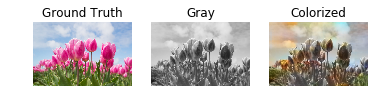

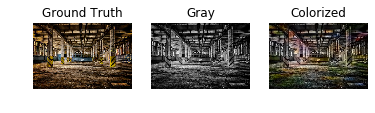

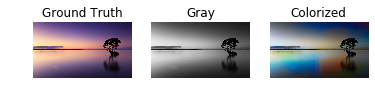

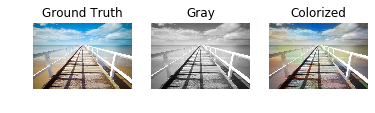

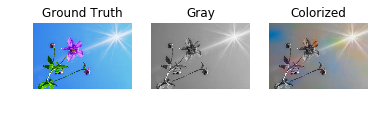

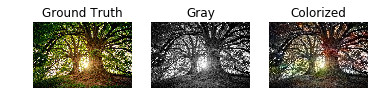

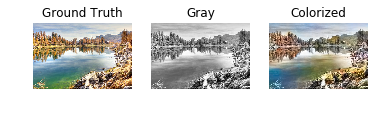

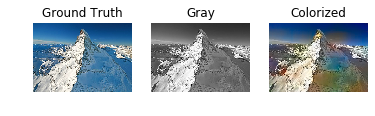

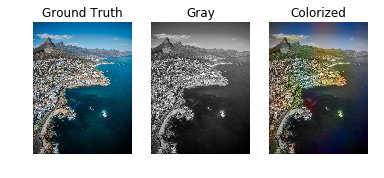

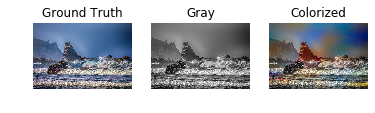

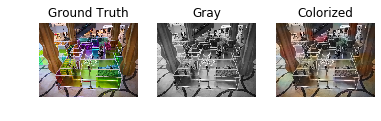

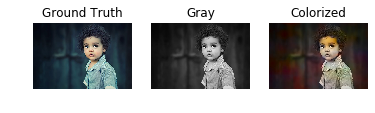

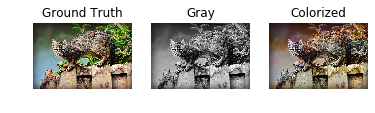

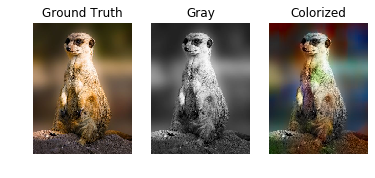

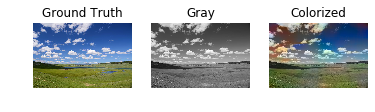

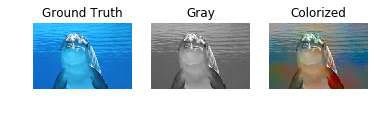

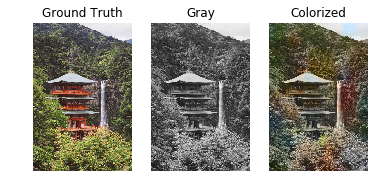

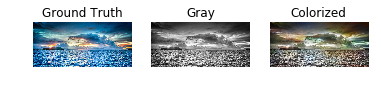

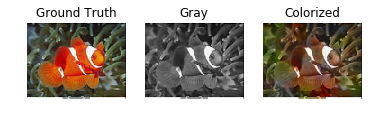

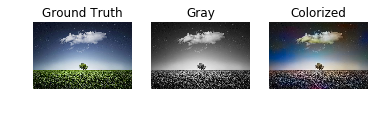

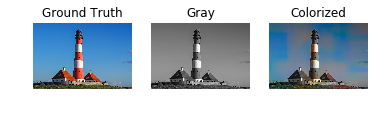

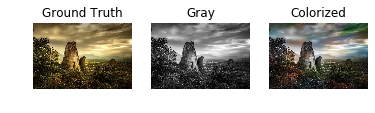

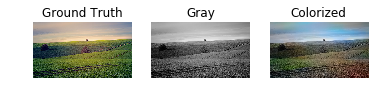

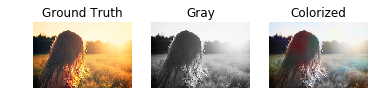

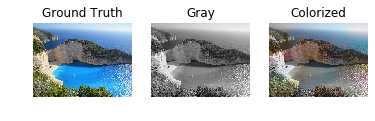

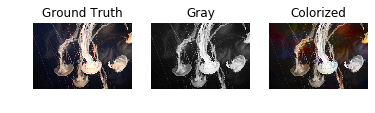

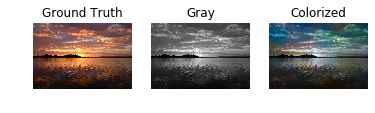

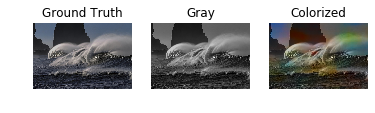

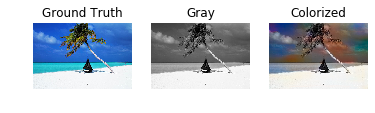

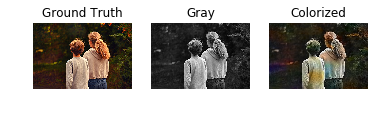

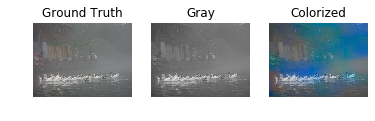

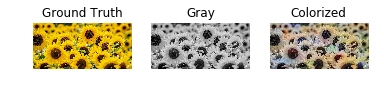

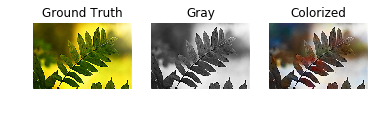

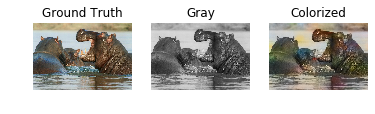

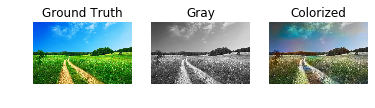

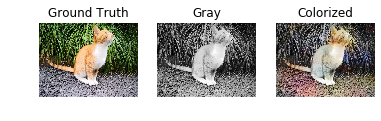

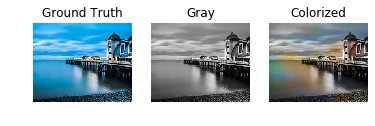

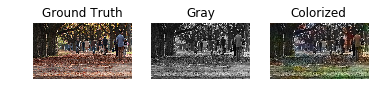

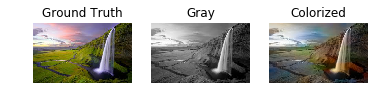

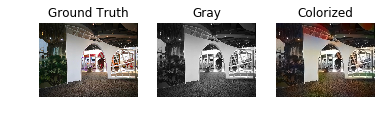

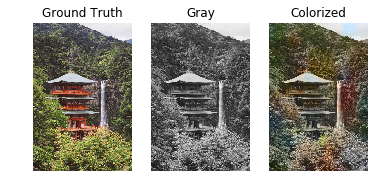

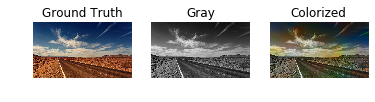

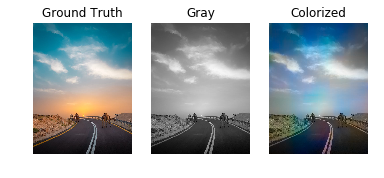

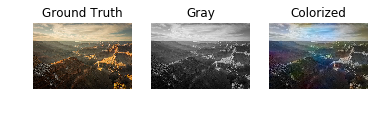

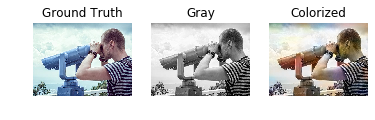

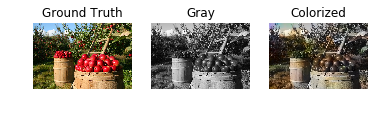

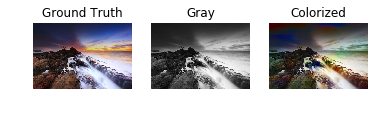

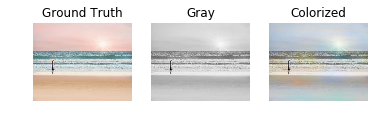

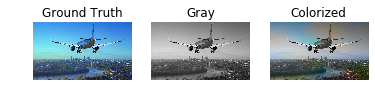

In [29]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
for filename in os.listdir('dataset/'):
    test_image = img_to_array(load_img('dataset/' + filename))
    image_gray = gray2rgb(rgb2gray(test_image))
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(test_image / 255.0)
    plt.title('Ground Truth')
    plt.axis('off');
    plt.subplot(1, 3, 2)
    plt.imshow(image_gray / 255.0)
    plt.title('Gray')
    plt.axis('off')
    colorized = colorizer.colorize(image_gray)
    plt.subplot(1, 3, 3)
    plt.imshow(adjust_saturation(colorized, 1.2))
    plt.title('Colorized')
    plt.axis('off');
    imsave('results/colorized/' + 'colorized_' + filename, colorized)
    imsave('results/gray/' + 'gray_' + filename, image_gray / 255.0)